_This notebook contains code and comments from Section 6.5 of the book [Ensemble Methods for Machine Learning](https://www.manning.com/books/ensemble-methods-for-machine-learning). Please see the book for additional details on this topic. This notebook and code are released under the [MIT license](https://github.com/gkunapuli/ensemble-methods-notebooks/blob/master/LICENSE)._

___

## Estudio de caso: recuperación de documentos
La recuperación de documentos es la tarea de recuperar documentos de una base de datos para que coincidan con la consulta de un usuario. Por ejemplo, un asistente legal en un bufete de abogados podría necesitar buscar información sobre casos anteriores en archivos legales para establecer precedentes e investigar jurisprudencia. O tal vez un estudiante de posgrado necesite buscar artículos en la base de datos de una revista durante el curso de una encuesta bibliográfica sobre el trabajo en un área específica.

En este estudio de caso, el problema se configura como un problema de clasificación de 3 clases para identificar el rango/clase de relevancia (menos, moderadamente o muy relevante) dado un par consulta-documento. Exploramos el desempeño de diferentes clasificadores ``XGBoost`` para esta tarea.

### El conjunto de datos LETOR
El conjunto de datos que usaremos para este estudio de caso se llama LEARNING TO Rank (LETOR) ver. 4.0, que a su vez se creó a partir de un gran corpus de páginas web llamado GOV2. El [conjunto de datos GOV2](http://ir.dcs.gla.ac.uk/test_collections/access_to_data.html) es una colección de aproximadamente 25 millones de páginas web extraídas del dominio .gov.

La recopilación de datos de LETOR 4.0 se deriva del corpus GOV2 y Microsoft Research la pone a disposición de forma gratuita. La colección contiene varios conjuntos de datos, y usaremos el conjunto de datos que se desarrolló originalmente para el segmento Million Query de la Conferencia de recuperación de texto (TREC) de 2008, específicamente, [MQ2008.rar](https://www.microsoft.com/en-us/research/project/letor-learning-rank-information-retrieval/#!letor-4-0).

In [1]:
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import numpy as np

# Load the data
query_data_file = './data/ch05/MQ2008/Querylevelnorm.txt'
X, y = load_svmlight_file(query_data_file)

# Split into train and test sets
Xtrn, Xtst, ytrn, ytst = train_test_split(X, y, test_size=0.2, random_state=42)

### Recuperación de documentos con XGBoost

In [2]:
# # Get results of the LightGBM runs
# cv_scores = {'rf': 0.8051450187962624, 'gbdt': 0.8122129268166652, 'goss': 0.8131167212266558, 'dart': 0.8155001366110529}
# tst_scores = {'rf': 0.8034834045349983, 'gbdt': 0.8120276043378245, 'goss': 0.8139993427538613, 'dart': 0.8245152809727243}
# run_time = {'rf': 122.31625509262085, 'gbdt': 23.24663543701172, 'goss': 19.403377532958984, 'dart': 1144.2085926532745}
import pickle
with open('./data/LightGBMMetrics.pickle', 'rb') as handle:
    metrics = pickle.load(handle)
print(metrics)

{'cv_scores': {'RF': 0.7931469208814301, 'GBDT': 0.8119661826008515, 'GOSS': 0.812212690406932, 'DART': 0.8178834169041739}, 'tst_scores': {'RF': 0.7982254354255669, 'GBDT': 0.8153138350312192, 'GOSS': 0.8136707196845219, 'DART': 0.8189286887939533}, 'run_times': {'RF': 85.58353352546692, 'GBDT': 15.024551391601562, 'GOSS': 16.530913829803467, 'DART': 786.1832556724548}}


In [3]:
from xgboost import DMatrix, XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import time

In [4]:
from scipy.stats import randint, uniform
xgb_params = {'max_depth': randint(2, 10), 
              'learning_rate': 2**np.linspace(-6, 2, num=5),
              'min_child_weight': [1e-2, 1e-1, 1, 1e1, 1e2],
              'colsample_bytree': uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0, 1e-1, 1, 10, 100],
              'reg_lambda': [0, 1e-1, 1, 10, 100]}

In [5]:
# NOTA MUY IMPORTANTE

# XGBoost lanza muuuchos warnings, podemos eliminarlos usando
import warnings
warnings.filterwarnings('ignore')

In [6]:
start = time.time()
xgb = XGBClassifier(booster='gbtree', objective='multi:softmax', eval_metric='merror', use_label_encoder=False, n_jobs=-1)
num_random_iters = 20
num_cv_folds = 5
cv = RandomizedSearchCV(estimator=xgb, 
                        param_distributions=xgb_params,
                        n_iter=num_random_iters,
                        cv=num_cv_folds,  
                        refit=True,
                        random_state=42, verbose=1)
cv.fit(Xtrn, ytrn, eval_set=[(Xtst, ytst)], verbose=False)
metrics['run_times']['XGB'] = time.time() - start

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [7]:
print('XGBoost: Best score: {0}, best params: {1} '.format(cv.best_score_, cv.best_params_))
metrics['cv_scores']['XGB'] = cv.best_score_

ypred = cv.best_estimator_.predict(Xtst)
metrics['tst_scores']['XGB'] = accuracy_score(ytst, ypred)

XGBoost: Best score: 0.8157463066889432, best params: {'colsample_bytree': 0.4936111842654619, 'learning_rate': 0.25, 'max_depth': 8, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 100} 


In [8]:
# scores = np.c_[np.array(list(metrics['cv_scores'].values())), np.array(list(metrics['tst_scores'].values()))]
print(metrics)
with open('./data/XGBoostMetrics.pickle', 'wb') as handle:
    pickle.dump(metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)

{'cv_scores': {'RF': 0.7931469208814301, 'GBDT': 0.8119661826008515, 'GOSS': 0.812212690406932, 'DART': 0.8178834169041739, 'XGB': 0.8157463066889432}, 'tst_scores': {'RF': 0.7982254354255669, 'GBDT': 0.8153138350312192, 'GOSS': 0.8136707196845219, 'DART': 0.8189286887939533, 'XGB': 0.8186000657246139}, 'run_times': {'RF': 85.58353352546692, 'GBDT': 15.024551391601562, 'GOSS': 16.530913829803467, 'DART': 786.1832556724548, 'XGB': 135.29629278182983}}


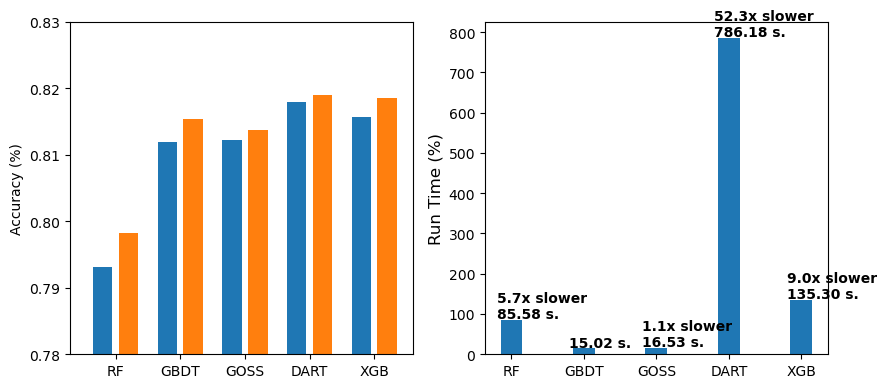

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

scores = np.array(list(metrics['cv_scores'].values()))
ax[0].bar(np.arange(1, 6)-0.2, scores, width=0.3)
scores = np.array(list(metrics['tst_scores'].values()))
ax[0].bar(np.arange(1, 6)+0.2, scores, width=0.3)
ax[0].axis([0.3, 5.6, 0.78, 0.83])
ax[0].set_ylabel('Accuracy (%)')
ax[0].set_xticks([1, 2, 3, 4, 5]);
ax[0].set_xticklabels(['RF', 'GBDT', 'GOSS', 'DART', 'XGB']);

times = np.array(list(metrics['run_times'].values()))
times_scaled = times / np.min(times)
ax[1].bar(np.arange(1, 6), times, width=0.3)
# for i, v in enumerate(times_scaled):
#     ax[1].text(i + 0.8, times[i] + 3.5, '{0:3.2f}%\n{1:4.2f} s.'.format(v, times[i]), fontweight='bold')
for i, v in enumerate(times_scaled):
    if i == 1:
        ax[1].text(i + 0.8, times[i] + 3.5, '\n{1:4.2f} s.'.format(v, times[i]), fontweight='bold')
    else:
        ax[1].text(i + 0.8, times[i] + 3.5, '{0:3.1f}x slower\n{1:4.2f} s.'.format(v, times[i]), fontweight='bold')


ax[1].set_ylabel('Run Time (%)', fontsize=12)
ax[1].set_xticks([1, 2, 3, 4, 5]);
ax[1].set_xticklabels(['RF', 'GBDT', 'GOSS', 'DART', 'XGB'])


fig.tight_layout()
#plt.savefig('./figures/CH06_F16_Kunapuli.png', format='png', dpi=300, bbox_inches='tight')
#plt.savefig('./figures/CH06_F16_Kunapuli.pdf', format='pdf', dpi=300, bbox_inches='tight')